# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.333825
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ Because we have 10 class.



In [17]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.403966 analytic: -1.519307, relative error: 3.945610e-02
numerical: 2.420291 analytic: 1.682041, relative error: 1.799586e-01
numerical: -1.135072 analytic: -1.305712, relative error: 6.991194e-02
numerical: 0.454499 analytic: 0.568446, relative error: 1.113919e-01
numerical: -1.755258 analytic: -2.084402, relative error: 8.572208e-02
numerical: -0.076186 analytic: 0.614296, relative error: 1.000000e+00
numerical: 0.243699 analytic: 1.015579, relative error: 6.129541e-01
numerical: -0.529846 analytic: -0.099695, relative error: 6.832776e-01
numerical: -0.515542 analytic: -0.190436, relative error: 4.605044e-01
numerical: 0.983205 analytic: 0.927489, relative error: 2.915983e-02
numerical: -0.013359 analytic: 0.473678, relative error: 1.000000e+00
numerical: -0.343348 analytic: -0.427712, relative error: 1.094139e-01
numerical: 0.054268 analytic: 1.125391, relative error: 9.079941e-01
numerical: 0.107851 analytic: -0.158256, relative error: 1.000000e+00
numerical: 0.067588

In [21]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.333825e+00 computed in 0.175912s
vectorized loss: 2.333825e+00 computed in 0.054968s
Loss difference: 0.000000
Gradient difference: 0.000000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools
# 其实就是调节超参数
experiments = itertools.product(learning_rates, regularization_strengths)
for lr, reg in experiments:
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=1500//3, verbose=True)
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % train_accuracy)
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % val_accuracy)
    results[(lr, reg)] = train_accuracy, val_accuracy
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

  0%|▏                                                                                 | 1/500 [00:00<06:07,  1.36it/s]

iteration 0 / 500: loss 773.684265


 20%|████████████████▏                                                               | 101/500 [01:00<03:03,  2.17it/s]

iteration 100 / 500: loss 285.928880


 40%|████████████████████████████████▎                                               | 202/500 [01:31<00:49,  6.04it/s]

iteration 200 / 500: loss 106.703932


 60%|████████████████████████████████████████████████▏                               | 301/500 [02:12<01:59,  1.66it/s]

iteration 300 / 500: loss 41.704094


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [02:57<00:30,  3.20it/s]

iteration 400 / 500: loss 17.541412


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:18<00:00,  2.52it/s]


training accuracy: 0.241694
validation accuracy: 0.263000


  0%|▏                                                                                 | 1/500 [00:00<06:12,  1.34it/s]

iteration 0 / 500: loss 1555.419086


 20%|████████████████▏                                                               | 101/500 [01:01<03:10,  2.10it/s]

iteration 100 / 500: loss 210.591302


 40%|████████████████████████████████▎                                               | 202/500 [01:33<00:50,  5.90it/s]

iteration 200 / 500: loss 30.600957


 60%|████████████████████████████████████████████████▏                               | 301/500 [02:15<02:05,  1.59it/s]

iteration 300 / 500: loss 6.346622


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [03:00<00:30,  3.23it/s]

iteration 400 / 500: loss 3.352623


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:20<00:00,  2.49it/s]


training accuracy: 0.243939
validation accuracy: 0.261000


  0%|▏                                                                                 | 1/500 [00:00<06:17,  1.32it/s]

iteration 0 / 500: loss 775.916584


 20%|████████████████▏                                                               | 101/500 [01:02<03:14,  2.05it/s]

iteration 100 / 500: loss 9.073553


 40%|████████████████████████████████▎                                               | 202/500 [01:34<00:49,  6.03it/s]

iteration 200 / 500: loss 4.380822


 60%|████████████████████████████████████████████████▏                               | 301/500 [02:16<02:03,  1.61it/s]

iteration 300 / 500: loss 4.135791


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [03:02<00:31,  3.16it/s]

iteration 400 / 500: loss 4.081018


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:23<00:00,  2.46it/s]


training accuracy: 0.243714
validation accuracy: 0.259000


  0%|▏                                                                                 | 1/500 [00:00<06:12,  1.34it/s]

iteration 0 / 500: loss 1517.065354


 20%|████████████████▏                                                               | 101/500 [01:01<03:07,  2.13it/s]

iteration 100 / 500: loss 3.251164


 40%|████████████████████████████████▎                                               | 202/500 [01:33<00:49,  5.99it/s]

iteration 200 / 500: loss 3.018845


 60%|████████████████████████████████████████████████▏                               | 301/500 [02:14<02:00,  1.65it/s]

iteration 300 / 500: loss 2.950802


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [03:00<00:31,  3.17it/s]

iteration 400 / 500: loss 2.999767


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:20<00:00,  2.49it/s]


training accuracy: 0.251245
validation accuracy: 0.272000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.241694 val accuracy: 0.263000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.243939 val accuracy: 0.261000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.243714 val accuracy: 0.259000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.251245 val accuracy: 0.272000
best validation accuracy achieved during cross-validation: 0.272000


In [23]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.274000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$
yes

$\color{blue}{\textit Your Explanation:}$
yes. if the SVM loss is unchanged, it means, wj * xi - w_class * xi + delta < 0 => w_class * xi - wj * xi > delta for all wj except w_class. Thus all wj * xi < w_class * xi - delta, this means all wj all weeker than the target w_class, as for recognizing xi.

for softmax, loss = -logP, this is entropy, p~(0, 1), then -logp ~(0, infinitive), therefore, softmax classifier always has a loss > 0 for a sample xi.

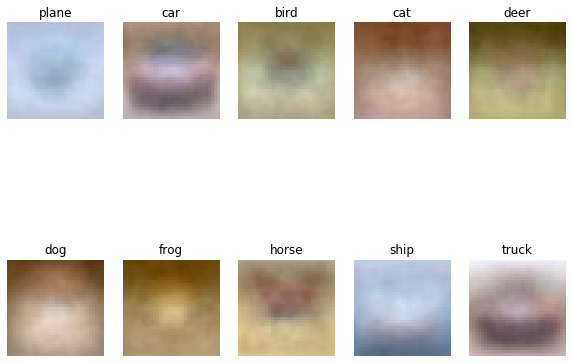

In [24]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])